# **Import libraries**

In [30]:
import csv
import numpy as np
import random
import torch

# **Personalized functions** 

In [31]:
def hasNumber(stringVal) :
  return any(elem.isdigit() for elem in stringVal)

In [32]:
def getDigit(stringVal) :
  onlyDigit = ''
  for i in stringVal :
    if (i.isdigit()) :
      onlyDigit += i
  return onlyDigit

In [81]:
def changeToNUM(measurement_list) :
  new_measurement_list = []
  for j in measurement_list : #measure
    if (hasNumber(j) == False) : #숫자가 하나도 없고 전부 문자열인 경우
      new_measurement_list.append(0)
    elif (j == '') : #빈 값인 경우 읽기 때문에 0으로 변경해줌
      new_measurement_list.append(0)

    else : #'1 1/2 oz' 형식으로 되어있음 따라서 공백으로 자르고 처리
      slice_str = []
      slice_str = j.split()
      total_val = 0
        
      for n in slice_str : #잘라진 '1' '1/2' 'oz' 처리
        if (n.isalpha()) :
          pass
        else :
          if (n.find('/') == -1) : #그냥 숫자인 경우
            num_tmp = getDigit(n)
            if (num_tmp == '') :
              num_tmp = 0
            total_val += int(num_tmp)
          else : # 1/2 인 경우
            idx = n.find('/')
            divide_val = int(n[:idx]) / int(n[idx+1:])
            total_val += divide_val
      new_measurement_list.append(total_val)
  return new_measurement_list

# **Read data from csv and pre-process data**

# **Label and ingredient set**

In [107]:
label_set = []
ingredient = []

f = open('mr-boston-flattened.csv','r')
rdr = csv.reader(f)

first_line_pass = 0
line_count = 0
for line in rdr:
  if (first_line_pass == 0) :
    first_line_pass += 1
    pass
  else :
    line_count += 1
    label_set.append(line[1])
    
    for i in range(3,15,2) :
      ingredient.append(line[i])

f.close()

label_set = set(label_set)
label_set = list(label_set)

#add wrong label
label_set.append("Wrong")

ingredient = set(ingredient)
ingredient = list(ingredient)

print("line len ", line_count)
print("label len", len(label_set))
print("label info :",label_set)
print("ingredient len", len(ingredient))

line len  990
label len 12
label info : ['Shooters', 'Whiskies', 'Non-alcoholic Drinks', 'Cocktail Classics', 'Cordials and Liqueurs', 'Rum - Daiquiris', 'Gin', 'Tequila', 'Brandy', 'Rum', 'Vodka', 'Wrong']
ingredient len 688


In [106]:
print(label_set)
print(label_set.append('Wrong'))

['Shooters', 'Whiskies', 'Non-alcoholic Drinks', 'Cocktail Classics', 'Cordials and Liqueurs', 'Rum - Daiquiris', 'Gin', 'Tequila', 'Brandy', 'Rum', 'Vodka', 'Wrong']
None


In [108]:
label = ['' for i in range(line_count)]
label_idx = [0 for i in range(line_count)]
ing = [[0 for col in range(len(ingredient))] for row in range(line_count)]

In [109]:
f = open('mr-boston-flattened.csv','r')
rdr = csv.reader(f)

first_line_pass = 0
line_count = 0
for line in rdr :
  if (first_line_pass == 0) :
    first_line_pass += 1
    pass
  else :

    #변수 초기화
    measurement_list = [] 
    ingred_idx = 3 #용량에 mapping 되는 ingredient idx
    
    for i in range(2,14,2) : #각 row에 measurement 뽑아서 list에 넣기
      measurement_list.append(line[i])

    #ingredient string 을 숫자만 남김
    new_measurement_list = changeToNUM(measurement_list)
    
    #전체 용량 계산하는 부분 필요한 경우 다시 활성화
    #total_measurement_value = sum(new_measurement_list)

    #칵테일 라벨
    label[line_count] = line[1]
    label_idx[line_count] = label_set.index(line[1])

    #숫자로 변환한 것들에 대응하는 재료를 전체 ingredient 리스트에서 해당 하는 인덱스 찾은 후 위치에 값 설정하기
    for j in new_measurement_list :
      if (line[ingred_idx] != '') :
        ing_measure_pair = {line[ingred_idx] : j}
        idx = ingredient.index(line[ingred_idx])
        ing[line_count][idx] = j
      ingred_idx += 2

    line_count += 1 #line idx 역할

f.close()

# **See the ingredient list**

In [ ]:
# for i in ing :
#   print(i)
# print("ing row num",len(ing))
# print("ing col num",len(ing[0]))

# **See the label list**

In [ ]:
# for i in label :
#   print(i)

# print("label row num",len(label))

# **Random Data Generator**

In [98]:
RandomGenerateNum = 1000

for i in range(RandomGenerateNum):
    generated_recipe = [] # 추가할 wrong label 레시피
    relation = np.zeros(len(ing[0]))
    ingredient_index = random.randrange(0, len(ing[0]) - 1)
    generated_recipe = np.zeros(len(ing[0]))
    label.append('Wrong')
    label_idx.append(label_set.index('Wrong'))
    for _ in range (random.randrange(2,5)):
        generated_recipe[ingredient_index] = round(random.randint(1,10) * 0.2, 1)
        for j in range (len(ing)):
            if ing[j][ingredient_index] != 0:
                for t in range(len(ing[0])):
                    if ing[j][t] != 0:
                        relation[t] += 1
        ingredient_index = np.argmin(relation)
    # print(generated_recipe)
    ing.append(generated_recipe)



# **Data Shuffling**

In [110]:
import random

random.Random(4).shuffle(ing)
random.Random(4).shuffle(label_idx)
random.Random(4).shuffle(label)
print("데이터: ",np.shape(ing))
print("label:", np.shape(label_idx))


데이터:  (990, 688)
label: (990,)


# **Make Model**

In [111]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=len(ing[0])))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_set), activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# **Training**

In [112]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import utils as np_utils
one_hot_labels = np_utils.to_categorical(label_idx, num_classes=len(label_set))
train_size = int(len(label) * 0.8)
train_x = np.array(ing[:train_size])
train_y = np.array(one_hot_labels[:train_size])
test_x = np.array(ing[train_size:])
test_y = np.array(one_hot_labels[train_size:])
model.fit(
    train_x, train_y,
    epochs=30, batch_size=32,
    )
score = model.evaluate(test_x, test_y, batch_size=32)
print(score)

Epoch 1/30
25/25 [==============================] - 1s 7ms/step - loss: 0.7096 - accuracy: 0.0808
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 0.4692 - accuracy: 0.1957
Epoch 3/30
25/25 [==============================] - 0s 7ms/step - loss: 0.3656 - accuracy: 0.2588
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.3540 - accuracy: 0.3220
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.2840 - accuracy: 0.3712
Epoch 6/30
25/25 [==============================] - 0s 7ms/step - loss: 0.2817 - accuracy: 0.3902
Epoch 7/30
25/25 [==============================] - 0s 7ms/step - loss: 0.2393 - accuracy: 0.4318
Epoch 8/30
25/25 [==============================] - 0s 7ms/step - loss: 0.2237 - accuracy: 0.4735
Epoch 9/30
25/25 [==============================] - 0s 7ms/step - loss: 0.2179 - accuracy: 0.4798
Epoch 10/30
25/25 [==============================] - 0s 8ms/step - loss: 0.2014 - accuracy: 0.5000
Epoch 11/30
25/25 [

# **View Evaluation**

In [286]:
s_idx = 100 # 검사 하고 싶은 index 넣기

result = model.predict(test_x)
for idx in range(s_idx, len(test_x)):
    print("ingredients---------------")
    for i, measure in enumerate(test_x[idx]):
        if measure != 0:
            print(ingredient[i], end=",")
    print("")
    idxs = np.argsort(result[idx])
    print("=> 1: ",label_set[idxs[-1]], "2: ", label_set[idxs[-2]], "3: ",label_set[idxs[-3]])
    print("정답 : ", label_set[np.argmax(test_y[idx])])
    print("")

ingredients---------------
 orgeat or almond syrup, Brandy, Angostura Bitters,
=> 1:  Brandy 2:  Whiskies 3:  Cocktail Classics
정답 :  Brandy

ingredients---------------
, Lime wedge,Fresh mint leaves, Tawny port,
=> 1:  Wrong 2:  Vodka 3:  Cocktail Classics
정답 :  Wrong

ingredients---------------
 Egg White, Lemon Juice, Maraschino, Gin,
=> 1:  Cocktail Classics 2:  Whiskies 3:  Gin
정답 :  Cocktail Classics

ingredients---------------
 Grenadine, maraschino cherry, Raspberries, lemon twist, Orgeat Syrup,hot red pepper sauce,
=> 1:  Wrong 2:  Vodka 3:  Cocktail Classics
정답 :  Wrong

ingredients---------------
 cherry-flavored brandy, Orange juice, Sweet Vermouth, Blended Scotch Whiskey,
=> 1:  Whiskies 2:  Rum - Daiquiris 3:  Brandy
정답 :  Whiskies

ingredients---------------
 Cucumber slices, Blackberry liqueur,
=> 1:  Wrong 2:  Vodka 3:  Cocktail Classics
정답 :  Wrong

ingredients---------------
 Grenadine, Pineapple Juice, Fresh orange juice, Vodka,
=> 1:  Vodka 2:  Cocktail Classics 3:

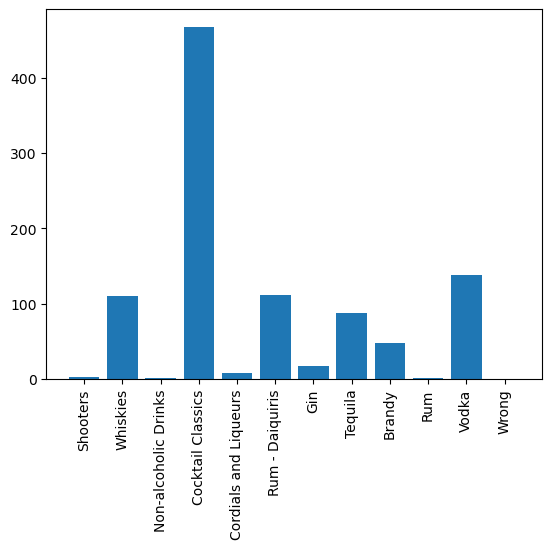

In [78]:
import matplotlib.pyplot as plt
import numpy as np

llist=[]
for i in range(len(label_set)):
    llist.append(label.count(label_set[i]))
x = np.arange(len(label_set))
plt.xticks(rotation=90)
plt.bar(x, llist)
plt.xticks(x, label_set)
plt.show()

In [113]:
class_correct = list(0. for i in range(len(label_set)))
class_total = list(0. for i in range(len(label_set)))
s_idx = 100 # 검사 하고 싶은 index 넣기

result = model.predict(np.array(ing))
_, predicted = torch.max(torch.Tensor(result), 1)
c = (predicted == torch.Tensor(label_idx)).squeeze()

for i in range(len(label_idx)):
    l = label_idx[i]
    class_correct[l] += c[i].item()
    class_total[l] += 1

print("total : ",len(label_idx))

for i in range(len(label_set)):
    if class_total[i] != 0 :
        print('Accuracy of %5s : %2d %% (%3d data)' % (label_set[i], 100 * class_correct[i] / class_total[i], label.count(label_set[i])))


total :  990
Accuracy of Shooters :  0 % (  2 data)
Accuracy of Whiskies : 95 % (110 data)
Accuracy of Non-alcoholic Drinks :  0 % (  1 data)
Accuracy of Cocktail Classics : 97 % (468 data)
Accuracy of Cordials and Liqueurs :  0 % (  8 data)
Accuracy of Rum - Daiquiris : 95 % (111 data)
Accuracy of   Gin :  0 % ( 17 data)
Accuracy of Tequila : 98 % ( 87 data)
Accuracy of Brandy : 10 % ( 47 data)
Accuracy of   Rum :  0 % (  1 data)
Accuracy of Vodka : 97 % (138 data)


In [ ]:
def newList():
    # my_data = []
    # f = open('mr-boston-flattened.csv','r')
    # rdr = csv.reader(f)

    # line_count = 0
    # for line in rdr :
    #   if (line_count == 0) :
    #     line_count += 1
    #     pass
    #   else :
    #     #변수 초기화
    #     cocktail = [] #우리 데이터 한 row
    #     cocktail_ingredient_measure = [] #칵테일 성분 정보(딕셔너리의 리스트로 구성 [{성분1 : 용량}, {성분2 : 용량}, ... ])
    #     measurement_list = [] 
    #     ingred_idx = 3 #용량에 mapping 되는 ingredient idx
    #     new_measurement_list = [] #변경한 값 담는 배열
        
    #     for i in range(2,14,2) : #각 row에 measurement 뽑아서 list에 넣기
    #       measurement_list.append(line[i])

    #     for j in measurement_list : #measure
    #       if (hasNumber(j) == False) : #숫자가 하나도 없고 전부 문자열인 경우
    #         new_measurement_list.append(0)
    #       elif (j == '') : #빈 값인 경우 읽기 때문에 0으로 변경해줌
    #         new_measurement_list.append(0)

    #       else : #'1 1/2 oz' 형식으로 되어있음 따라서 공백으로 자르고 처리
    #         slice_str = []
    #         slice_str = j.split()
    #         total_val = 0
            
    #         for n in slice_str : #잘라진 '1' '1/2' 'oz' 처리
    #           if (n.isalpha()) :
    #             pass
    #           else :
    #             if (n.find('/') == -1) : #그냥 숫자인 경우
    #               num_tmp = getDigit(n)

    #               if (num_tmp == '') :
    #                 num_tmp = 0

    #               total_val += int(num_tmp)
    #             else : # 1/2 인 경우
    #               idx = n.find('/')
    #               divide_val = int(n[:idx]) / int(n[idx+1:])
    #               total_val += divide_val
    #         new_measurement_list.append(total_val)
            

    # ### 여기까지 오면 new_measurement_list에는 숫자만 들어있음
    #     total_measurement_value = sum(new_measurement_list)

    #     for j in new_measurement_list :
    #       if (line[ingred_idx] != '') :

    #         ing_measure_pair = {line[ingred_idx] : j}
    #         cocktail_ingredient_measure.append(ing_measure_pair)
        
    #       ingred_idx += 2

    #     #칵테일 이름
    #     cocktail.append(line[0])
    #     #칵테일 라벨
    #     cocktail.append(line[1])
    #     #성분 전체 용량
    #     cocktail.append(total_measurement_value)
    #     #각 성분별 성분명, 용량 딕셔너리
    #     cocktail.append(cocktail_ingredient_measure)
    #     my_data.append(cocktail)

    # f.close()